# Librerias

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 8.9 MB 39.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 11.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 34.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 31.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle

# Colab-drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cargar caracteristicas

In [4]:
ruta = '/content/drive/MyDrive/Teoría de grafos/urban/Datos/DatosVGGish.pickle'

with open(ruta, 'rb') as data:
    unserialized_data = pickle.load(data)
    X_vgg = unserialized_data['X']
    y_vgg = unserialized_data['y']

In [5]:
X_tensor = torch.tensor(X_vgg, dtype=torch.float)
Y_tensor = torch.tensor(y_vgg, dtype=torch.uint8)

#GPU?

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Creacion de grafos

In [7]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from torch_geometric.utils import index_to_mask
from random import sample, shuffle

In [8]:
tensor = torch.tensor(range(0,len(y_vgg)))

In [9]:
l_val = sample(tensor.tolist(), round(len(y_vgg) * 0.1))
val_mask = index_to_mask(torch.tensor(l_val), len(y_vgg))

In [10]:
l_test = sample(tensor[~val_mask].tolist(), round(len(y_vgg) * 0.1))
test_mask = index_to_mask(torch.tensor(l_test), len(y_vgg))

In [11]:
l_train = val_mask + test_mask
train_mask = ~l_train

### Comprobar la distribución de los datos

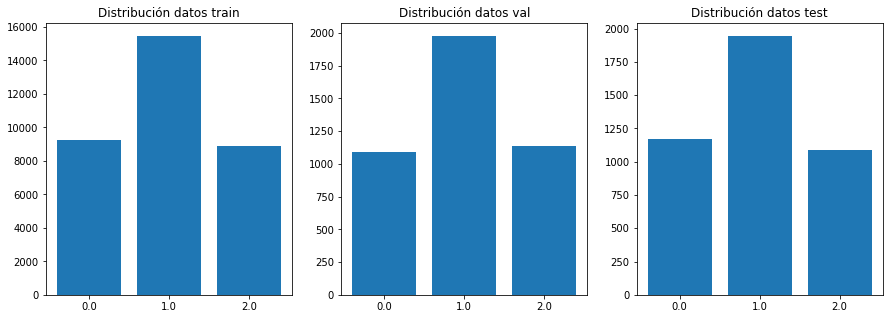

In [12]:
plt.figure(figsize = (15,5))
plt.subplot(131), plt.bar(np.unique(y_vgg), [np.sum(y_vgg[train_mask] == 0.0),np.sum(y_vgg[train_mask] == 1.0),np.sum(y_vgg[train_mask] == 2.0)], tick_label = np.unique(y_vgg)),plt.title('Distribución datos train')
plt.subplot(132), plt.bar(np.unique(y_vgg), [np.sum(y_vgg[val_mask] == 0.0),np.sum(y_vgg[val_mask] == 1.0),np.sum(y_vgg[val_mask] == 2.0)], tick_label = np.unique(y_vgg)),plt.title('Distribución datos val')
plt.subplot(133), plt.bar(np.unique(y_vgg), [np.sum(y_vgg[test_mask] == 0.0),np.sum(y_vgg[test_mask] == 1.0),np.sum(y_vgg[test_mask] == 2.0)], tick_label = np.unique(y_vgg)),plt.title('Distribución datos test')
plt.show()

In [13]:
#normalizacion
min = X_tensor[train_mask].min()
max = X_tensor[train_mask].max()
X_tensor_norm = (X_tensor - min) / (max - min)

In [14]:
x = X_tensor_norm

#Labels nodes

y = Y_tensor


#Se crea las conexines de los nodos

edge_index = knn_graph(x, k=4, batch=y, loop=False)


#Creacion del grafo 

data = Data(x=x, edge_index= edge_index, y = y , train_mask = train_mask, test_mask = test_mask, val_mask = val_mask)# edge_index tensor que define los nodos de origen y de destino.

In [15]:
data.edge_index

tensor([[    1,   275,     3,  ..., 41986, 40850, 41987],
        [    0,     0,     0,  ..., 41990, 41990, 41990]])

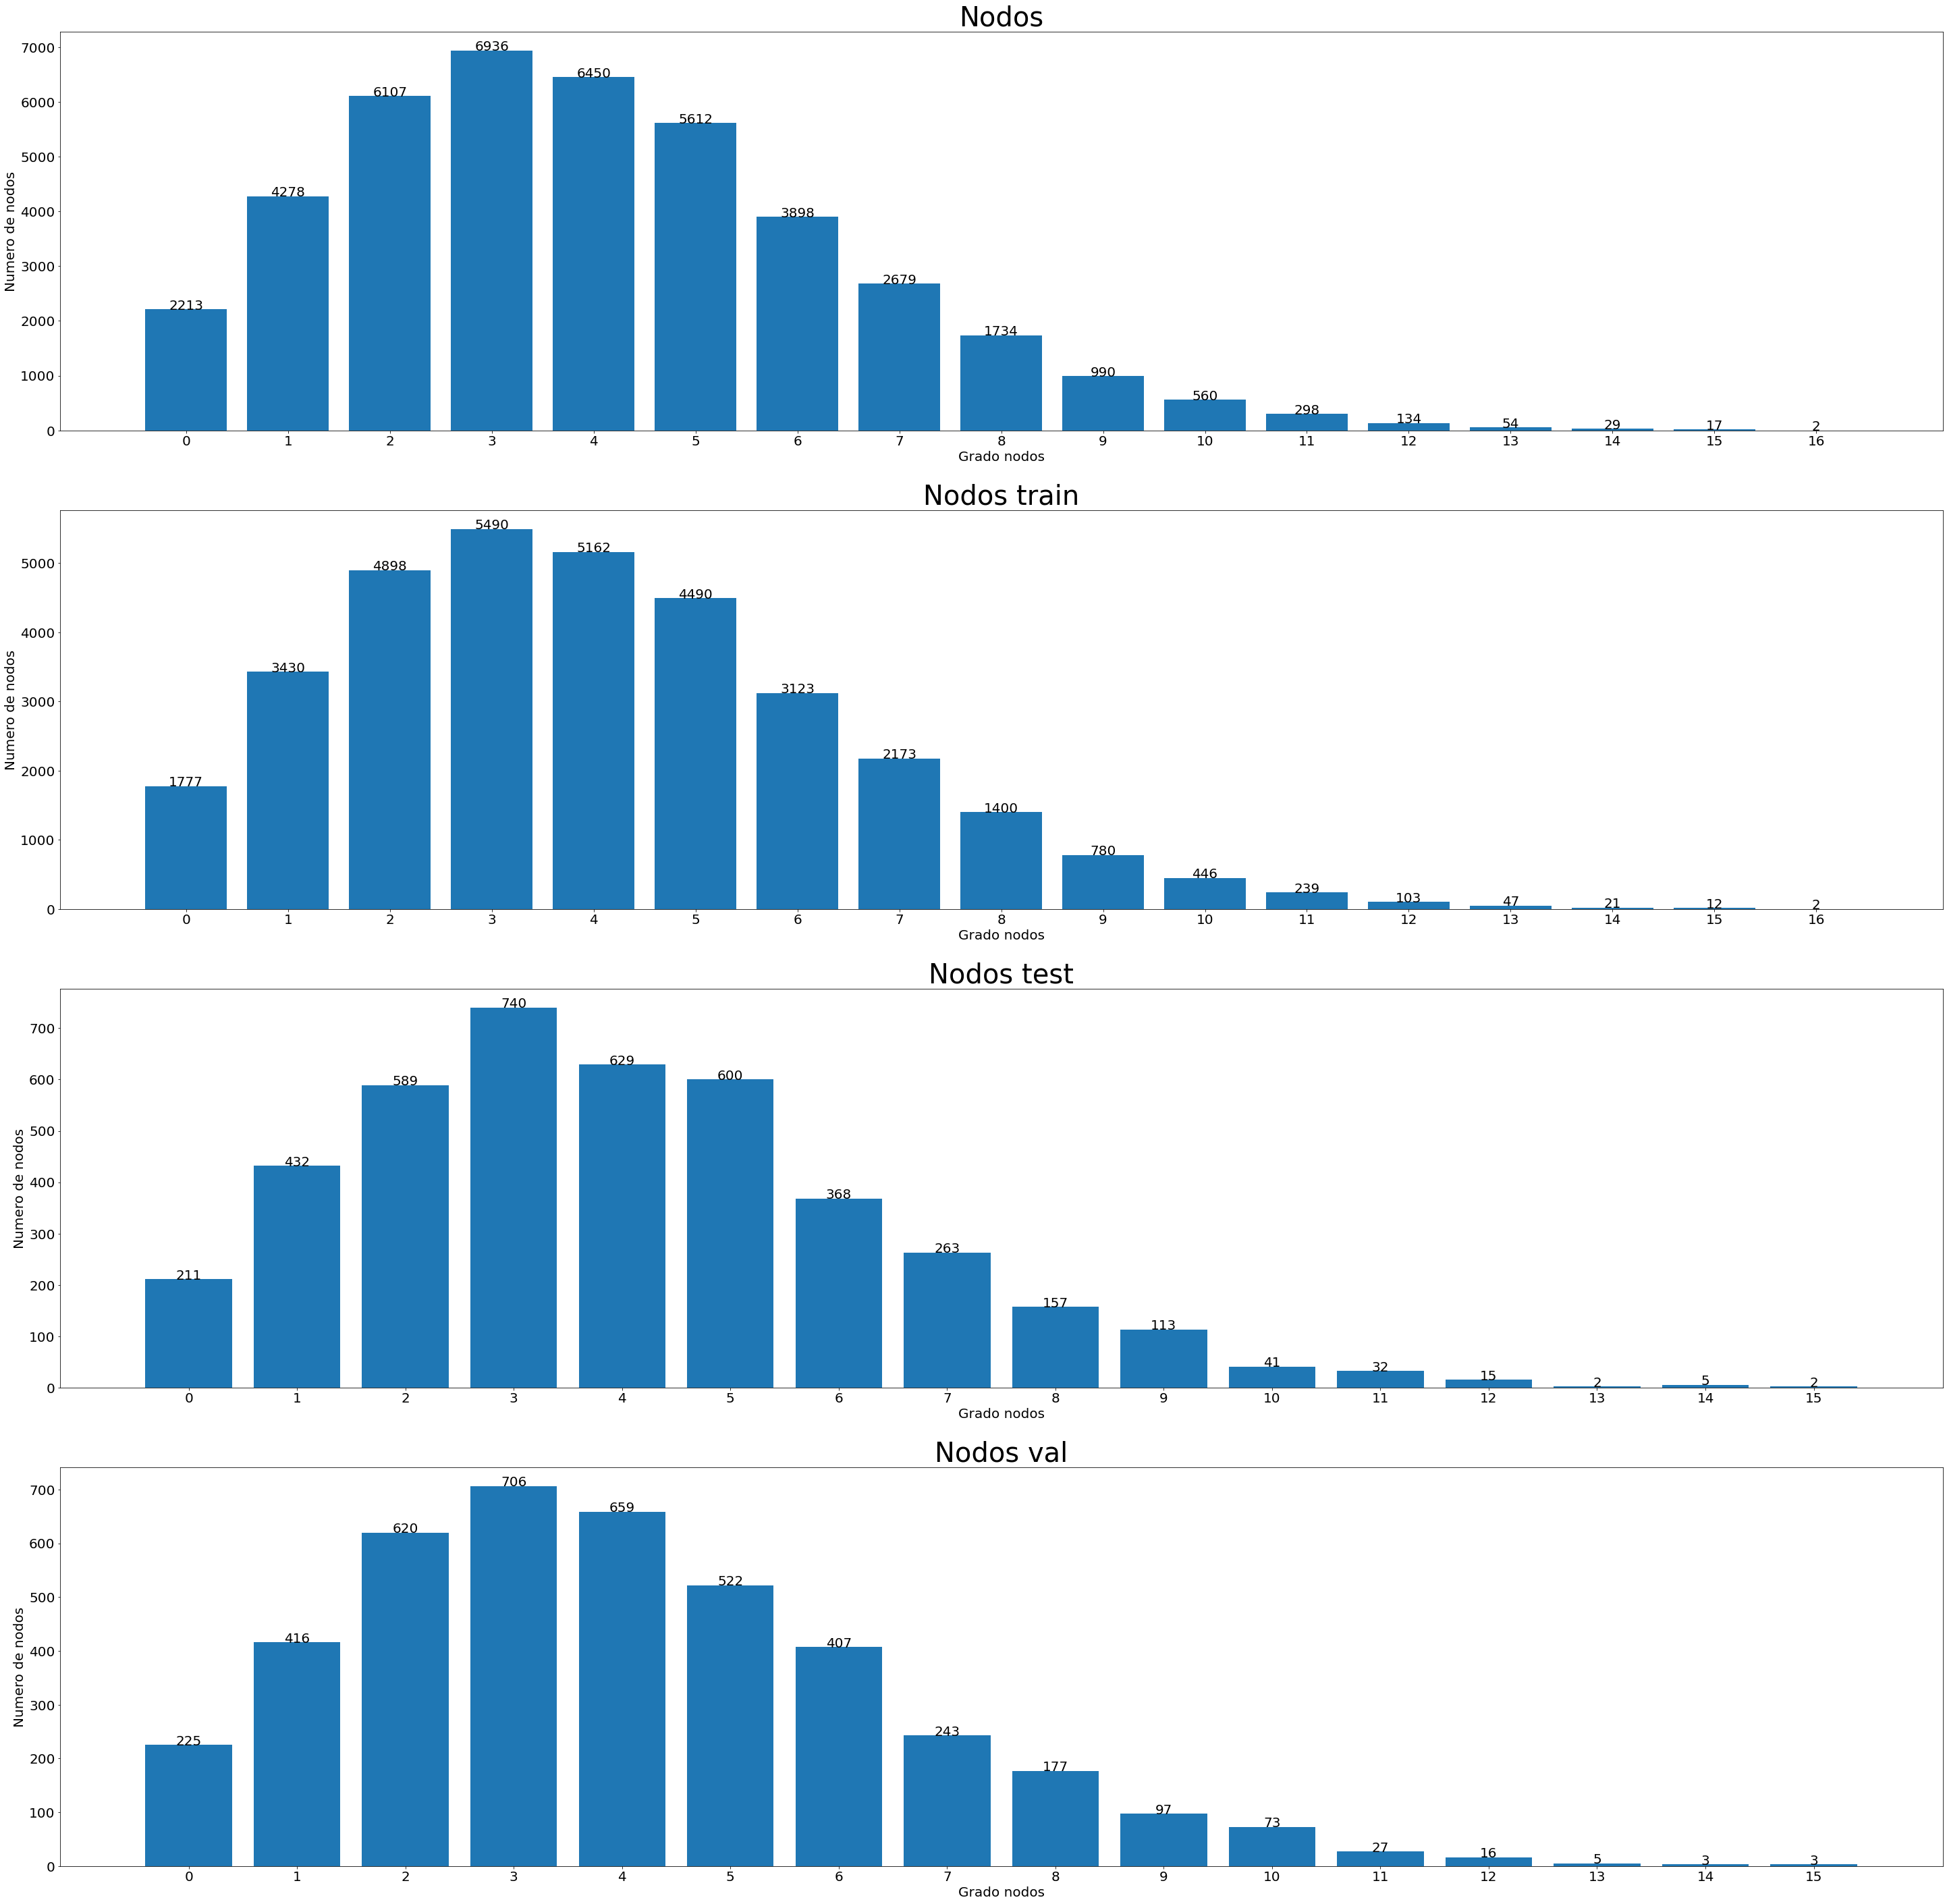

In [16]:
from torch_geometric.utils import degree
from collections import Counter


plt.figure(figsize = (50,50))
plt.rcParams.update({'font.size':20})

degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)

list_numbers_keys = list(map(lambda i: int(i), list(numbers.keys())))
list_numbers_values = list(map(lambda i: int(i), list(numbers.values())))

plt.subplot(411)

plt.title('Nodos',fontsize=40)
plt.xlabel('Grado nodos')
plt.ylabel('Numero de nodos')
plt.bar(list_numbers_keys,list_numbers_values, tick_label = list_numbers_keys)




for i in range(len(list_numbers_keys)):

  plt.text(list_numbers_keys[i],list_numbers_values[i],list_numbers_values[i], ha='center')



degrees_train = degrees[train_mask]
numbers_train = Counter(degrees_train)


list_numbers_train_keys = list(map(lambda i: int(i), list(numbers_train.keys())))
list_numbers_train_values = list(map(lambda i: int(i), list(numbers_train.values())))

plt.subplot(412)

plt.title('Nodos train',fontsize=40)
plt.xlabel('Grado nodos')
plt.ylabel('Numero de nodos')
plt.bar(list_numbers_train_keys,list_numbers_train_values, tick_label = list_numbers_train_keys)




for i in range(len(list_numbers_train_keys)):

  plt.text(list_numbers_train_keys[i],list_numbers_train_values[i],list_numbers_train_values[i], ha='center')


#====================================================================================================
degrees_test = degrees[test_mask]
numbers_test = Counter(degrees_test)


list_numbers_test_keys = list(map(lambda i: int(i), list(numbers_test.keys())))
list_numbers_test_values = list(map(lambda i: int(i), list(numbers_test.values())))



plt.subplot(413)

plt.title('Nodos test',fontsize=40)
plt.xlabel('Grado nodos')
plt.ylabel('Numero de nodos')


plt.xlabel('Grado nodos')
plt.ylabel('Numero de nodos')
plt.bar(list_numbers_test_keys,list_numbers_test_values, tick_label = list_numbers_test_keys)




for i in range(len(list_numbers_test_keys)):

  plt.text(list_numbers_test_keys[i],list_numbers_test_values[i],list_numbers_test_values[i], ha='center')


#====================================================================================================

degrees_val = degrees[val_mask]
numbers_val = Counter(degrees_val)


list_numbers_val_keys = list(map(lambda i: int(i), list(numbers_val.keys())))
list_numbers_val_values = list(map(lambda i: int(i), list(numbers_val.values())))

plt.subplot(414),

plt.title('Nodos val',fontsize=40)
plt.xlabel('Grado nodos')
plt.ylabel('Numero de nodos')
plt.bar(list_numbers_val_keys,list_numbers_val_values, tick_label = list_numbers_val_keys)




for i in range(len(list_numbers_val_keys)):

  plt.text(list_numbers_val_keys[i],list_numbers_val_values[i],list_numbers_val_values[i], ha='center')

plt.show()

In [17]:
data.to(device)

Data(x=[41991, 128], edge_index=[2, 167964], y=[41991], train_mask=[41991], test_mask=[41991], val_mask=[41991])

# Train Test Val

In [25]:
def accuracy(pred_y, y):
    
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data, mask):
    
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(torch.argmax(out, dim = 1)[mask], data.y[mask])
    return acc

def train(model, data, epoch):
    
    f_loss = nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = epoch

    model.train()
    for epoch in range(epochs+1):
        
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = f_loss(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(torch.argmax(out, dim = 1)[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        
        
        val_acc = test(model, data, data.val_mask)

        
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% |' f'Val Acc: {val_acc*100:.2f}%')
          
    return model

# Modelos

In [26]:
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv

## GAT

In [27]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=10):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gat2(h, edge_index)
  
    return h

In [28]:
gat = GAT(128, 20, 3).to(device)

In [29]:
train(gat, data, epoch = 500)
ac = test(gat, data, data.test_mask)
print(f"=============================================================\nAccuracy: {ac*100:.2f}%")

Epoch   0 | Train Loss: 1.123 | Train Acc:  38.56% |Val Acc: 47.08%
Epoch  10 | Train Loss: 0.969 | Train Acc:  49.97% |Val Acc: 53.20%
Epoch  20 | Train Loss: 0.914 | Train Acc:  55.85% |Val Acc: 57.16%
Epoch  30 | Train Loss: 0.876 | Train Acc:  57.65% |Val Acc: 59.42%
Epoch  40 | Train Loss: 0.847 | Train Acc:  59.62% |Val Acc: 60.59%
Epoch  50 | Train Loss: 0.823 | Train Acc:  61.63% |Val Acc: 61.92%
Epoch  60 | Train Loss: 0.803 | Train Acc:  63.08% |Val Acc: 63.56%
Epoch  70 | Train Loss: 0.784 | Train Acc:  64.54% |Val Acc: 64.61%
Epoch  80 | Train Loss: 0.767 | Train Acc:  65.69% |Val Acc: 66.04%
Epoch  90 | Train Loss: 0.752 | Train Acc:  67.12% |Val Acc: 66.47%
Epoch 100 | Train Loss: 0.738 | Train Acc:  67.74% |Val Acc: 68.40%
Epoch 110 | Train Loss: 0.725 | Train Acc:  68.68% |Val Acc: 68.68%
Epoch 120 | Train Loss: 0.713 | Train Acc:  69.50% |Val Acc: 69.54%
Epoch 130 | Train Loss: 0.702 | Train Acc:  70.51% |Val Acc: 69.85%
Epoch 140 | Train Loss: 0.690 | Train Acc:  71.1

## GCN

In [30]:
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    
    return h

In [31]:
gcn = GCN(128, 10, 3).to(device)

In [32]:
train(gcn, data, epoch = 500)
ac = test(gcn, data, data.test_mask)
print(f"=============================================================\nAccuracy: {ac*100:.2f}%")

Epoch   0 | Train Loss: 1.463 | Train Acc:  27.65% |Val Acc: 25.34%
Epoch  10 | Train Loss: 1.097 | Train Acc:  44.82% |Val Acc: 46.25%
Epoch  20 | Train Loss: 1.069 | Train Acc:  44.21% |Val Acc: 44.94%
Epoch  30 | Train Loss: 1.061 | Train Acc:  45.43% |Val Acc: 46.18%
Epoch  40 | Train Loss: 1.044 | Train Acc:  44.74% |Val Acc: 45.34%
Epoch  50 | Train Loss: 1.030 | Train Acc:  46.12% |Val Acc: 46.46%
Epoch  60 | Train Loss: 1.017 | Train Acc:  45.99% |Val Acc: 46.61%
Epoch  70 | Train Loss: 1.005 | Train Acc:  46.89% |Val Acc: 47.42%
Epoch  80 | Train Loss: 0.993 | Train Acc:  47.49% |Val Acc: 48.15%
Epoch  90 | Train Loss: 0.982 | Train Acc:  48.22% |Val Acc: 49.25%
Epoch 100 | Train Loss: 0.972 | Train Acc:  49.99% |Val Acc: 51.04%
Epoch 110 | Train Loss: 0.962 | Train Acc:  51.86% |Val Acc: 52.39%
Epoch 120 | Train Loss: 0.952 | Train Acc:  53.51% |Val Acc: 54.49%
Epoch 130 | Train Loss: 0.944 | Train Acc:  54.54% |Val Acc: 55.54%
Epoch 140 | Train Loss: 0.935 | Train Acc:  55.4

## SAGE

In [33]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.001,
                                      weight_decay=5e-4)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5)
        h = self.conv1(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.5)
        h = self.conv2(h, edge_index)
       
        return h

In [34]:
g_sage = GraphSAGE(128, 30, 3).to(device)

In [37]:
train(g_sage, data, epoch = 500)
ac = test(g_sage,data, data.test_mask)
print(f"=============================================================\nAccuracy: {ac*100:.2f}%")

Epoch   0 | Train Loss: 0.738 | Train Acc:  66.68% |Val Acc: 66.16%
Epoch  10 | Train Loss: 0.734 | Train Acc:  66.85% |Val Acc: 68.87%
Epoch  20 | Train Loss: 0.735 | Train Acc:  67.11% |Val Acc: 67.92%
Epoch  30 | Train Loss: 0.728 | Train Acc:  67.53% |Val Acc: 67.40%
Epoch  40 | Train Loss: 0.737 | Train Acc:  66.93% |Val Acc: 66.78%
Epoch  50 | Train Loss: 0.727 | Train Acc:  67.33% |Val Acc: 67.02%
Epoch  60 | Train Loss: 0.722 | Train Acc:  67.68% |Val Acc: 68.02%
Epoch  70 | Train Loss: 0.725 | Train Acc:  67.61% |Val Acc: 68.85%
Epoch  80 | Train Loss: 0.722 | Train Acc:  67.25% |Val Acc: 68.99%
Epoch  90 | Train Loss: 0.728 | Train Acc:  67.34% |Val Acc: 68.78%
Epoch 100 | Train Loss: 0.723 | Train Acc:  67.31% |Val Acc: 68.47%
Epoch 110 | Train Loss: 0.719 | Train Acc:  68.40% |Val Acc: 67.85%
Epoch 120 | Train Loss: 0.726 | Train Acc:  66.99% |Val Acc: 67.92%
Epoch 130 | Train Loss: 0.725 | Train Acc:  66.93% |Val Acc: 68.44%
Epoch 140 | Train Loss: 0.719 | Train Acc:  67.5